In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import keras

In [2]:
tf.debugging.set_log_device_placement(False)

In [ ]:
# Check if GPU is available
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Place tensors on the CPU
with tf.device('/CPU:0'):
  a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
  b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
  c = tf.matmul(a, b)
print(c)

# Place tensors on the GPU
with tf.device('/GPU:0'):
  a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
  b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
  c = tf.matmul(a, b)
print(c)

In [21]:
# Set random seed for reproducibility
np.random.seed(2488)

# Set model name
model_name = "dcgan_fashion"

# Set the dimensions of our noise vector
noise_dim = 100

# Set the training parameters
batch_size = 16
steps_per_epoch = 1000
epochs = 10

# Set the dimensions of our image
img_rows, img_cols, channels = 28, 28, 1

# Set the optimizer
optimizer = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

In [4]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

x_train = (x_train.astype(np.float32) - 127.5) / 127.5
x_train = x_train.reshape(-1, img_rows, img_cols, channels)
x_train = x_train[np.where(y_train == 0)[0]]

In [16]:
from keras.initializers import RandomNormal

# Build the generator
def build_generator():
    generator = keras.models.Sequential()
    
    d = 7
    generator.add(keras.layers.Dense(d*d*256, kernel_initializer=RandomNormal(0, 0.02), input_dim=noise_dim))
    generator.add(keras.layers.LeakyReLU(0.2))
    generator.add(keras.layers.Dropout(0.2))
    
    generator.add(keras.layers.Reshape((d, d, 256)))
    
    generator.add(keras.layers.Conv2DTranspose(256, (4, 4), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    generator.add(keras.layers.LeakyReLU(0.2))
    generator.add(keras.layers.Dropout(0.2))

    generator.add(keras.layers.Conv2DTranspose(128, (4, 4), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    generator.add(keras.layers.LeakyReLU(0.2))
    generator.add(keras.layers.Dropout(0.2))
    
    generator.add(keras.layers.Conv2D(channels, (3, 3), padding='same', activation='tanh', kernel_initializer=RandomNormal(0, 0.02)))
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    
    return generator

In [14]:
from keras.initializers import RandomNormal

# Build the discriminator
def build_discriminator():
    discriminator = keras.models.Sequential()
    
    discriminator.add(keras.layers.Conv2D(64, (3, 3), padding='same', kernel_initializer=RandomNormal(0, 0.02), input_shape=(img_cols, img_rows, channels)))
    discriminator.add(keras.layers.LeakyReLU(0.2))
    discriminator.add(keras.layers.Dropout(0.2))
    
    discriminator.add(keras.layers.Conv2D(128, (3, 3), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    discriminator.add(keras.layers.LeakyReLU(0.2))
    discriminator.add(keras.layers.Dropout(0.2))
    
    discriminator.add(keras.layers.Conv2D(256, (3, 3), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    discriminator.add(keras.layers.LeakyReLU(0.2))
    discriminator.add(keras.layers.Dropout(0.2))
    
    discriminator.add(keras.layers.Conv2D(512, (3, 3), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    discriminator.add(keras.layers.LeakyReLU(0.2))    
    discriminator.add(keras.layers.Flatten())
    discriminator.add(keras.layers.Dropout(0.4))
    
    discriminator.add(keras.layers.Dense(1, activation='sigmoid', input_shape=(img_cols, img_rows, channels)))
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    
    return discriminator

In [18]:
# Build and compile the discriminator/generator
discriminator = build_discriminator()
generator = build_generator()

# Make the discriminator not trainable
discriminator.trainable = False

# Build the GAN layers
gan_input = keras.layers.Input(shape=(noise_dim,))
fake_image = generator(gan_input)
gan_output = discriminator(fake_image)

# Compile the GAN model
gan = keras.models.Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer=optimizer)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 12544)             1266944   
                                                                 
 leaky_re_lu_27 (LeakyReLU)  (None, 12544)             0         
                                                                 
 dropout_27 (Dropout)        (None, 12544)             0         
                                                                 
 reshape_3 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_8 (Conv2DT  (None, 14, 14, 256)      1048832   
 ranspose)                                                       
                                                                 
 leaky_re_lu_28 (LeakyReLU)  (None, 14, 14, 256)       0         
                                                      

In [19]:
#Code for plotting results
def show_images(noise, size_fig, epoch):
    generated_images = generator.predict(noise, verbose=False)
    plt.figure(figsize=size_fig)
    
    for i, image in enumerate(generated_images):
        plt.subplot(size_fig[0], size_fig[1], i+1)
        if channels == 1:
            plt.imshow(image.reshape((img_rows, img_cols)), cmap='gray')
        else:
            plt.imshow(image.reshape((img_rows, img_cols, channels)))
        plt.axis('off')
    
    plt.tight_layout()
    filename = f"{model_name}_plot_e{epoch+1}.png"
    plt.savefig(f"images\\{model_name}\\{filename}")
    plt.show()

Epoch 1/10: [====================] 1000/1000  D-Loss: 0.45628  G-Loss: 1.40002


<Figure size 640x480 with 0 Axes>

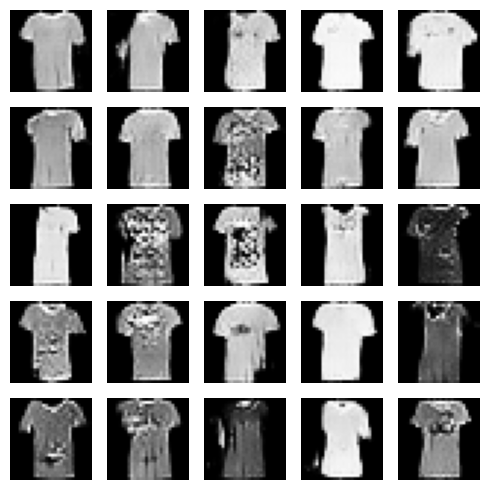

Epoch 2/10: [====================] 1000/1000  D-Loss: 0.42926  G-Loss: 1.65771


<Figure size 640x480 with 0 Axes>

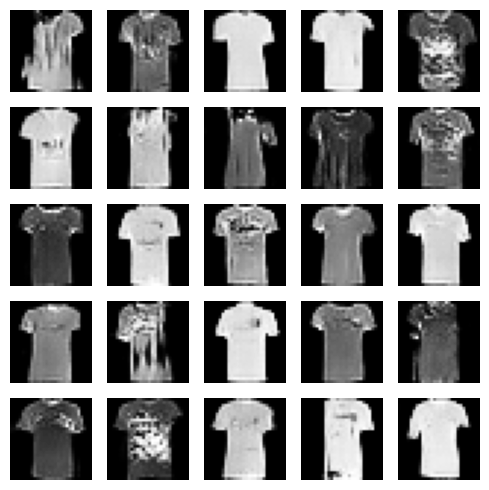

Epoch 3/10: [====================] 1000/1000  D-Loss: 0.56058  G-Loss: 1.57718


<Figure size 640x480 with 0 Axes>

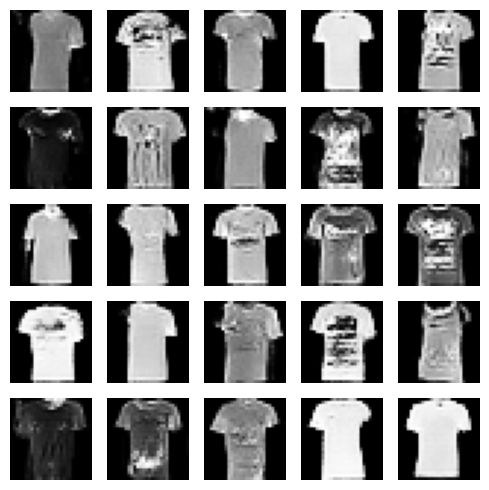

Epoch 4/10: [====================] 1000/1000  D-Loss: 0.54454  G-Loss: 2.06612


<Figure size 640x480 with 0 Axes>

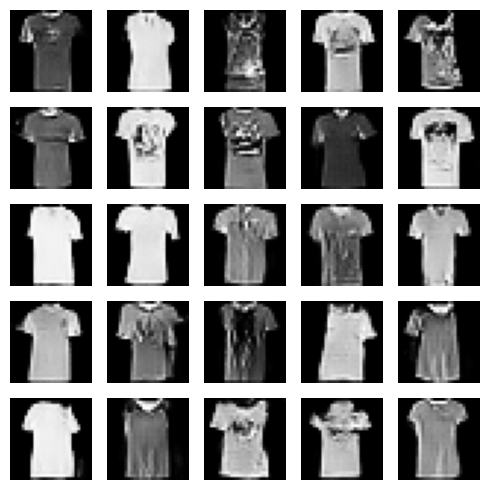

Epoch 5/10: [====================] 1000/1000  D-Loss: 0.39557  G-Loss: 1.2724


<Figure size 640x480 with 0 Axes>

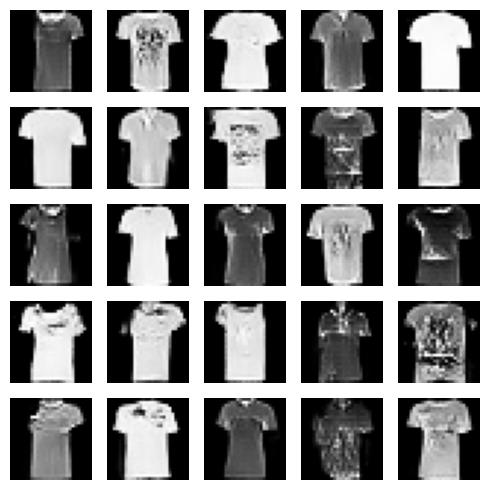

Epoch 6/10: [====================] 1000/1000  D-Loss: 0.6476  G-Loss: 1.41076


<Figure size 640x480 with 0 Axes>

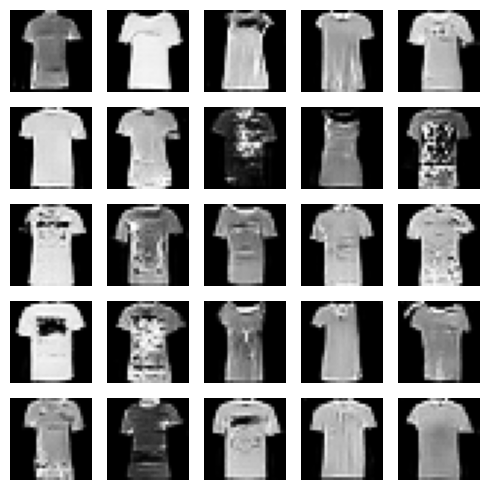

Epoch 7/10: [====================] 1000/1000  D-Loss: 0.51268  G-Loss: 1.34485


<Figure size 640x480 with 0 Axes>

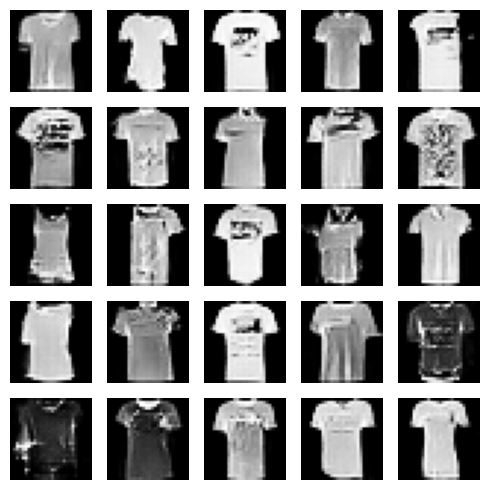

Epoch 8/10: [====================] 1000/1000  D-Loss: 0.55303  G-Loss: 1.28186


<Figure size 640x480 with 0 Axes>

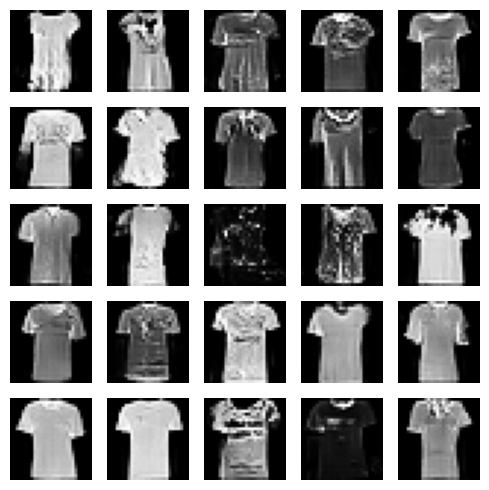

Epoch 9/10: [====================] 1000/1000  D-Loss: 0.40636  G-Loss: 1.50091


<Figure size 640x480 with 0 Axes>

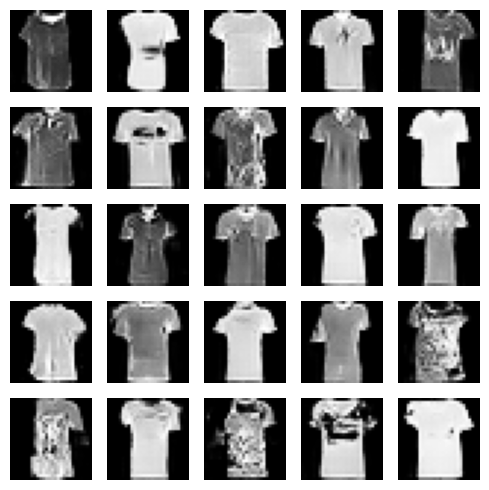

Epoch 10/10: [====================] 1000/1000  D-Loss: 0.58124  G-Loss: 1.78591


<Figure size 640x480 with 0 Axes>

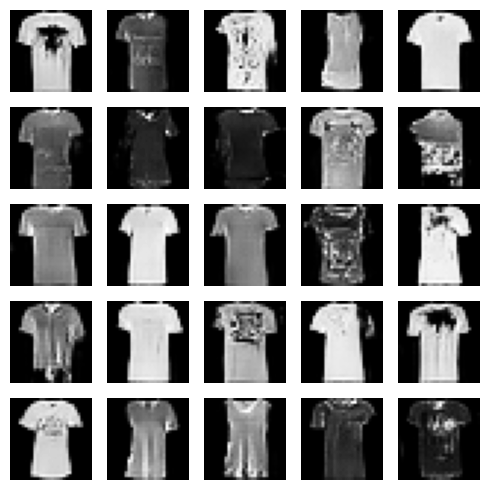

In [22]:
with tf.device('/GPU:0'):
    for epoch in range(epochs):
        for batch in range(steps_per_epoch):
            # Generate noise and fake images with the generator
            noise = np.random.normal(0, 1, size=(batch_size, noise_dim))
            x_fake = generator.predict(noise, verbose=False)

            # Get real images from the dataset and concatenate with fake images
            x_real = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]
            x = np.concatenate((x_real, x_fake))

            # Create labels for real and fake images
            y_disc = np.zeros(2*batch_size)
            y_disc[:batch_size] = 1

            # Train the discriminator on the images
            d_loss = discriminator.train_on_batch(x, y_disc)

            # Train GAN on the noise
            y_gen = np.ones(batch_size)
            g_loss = gan.train_on_batch(noise, y_gen)
            
            # Print progress
            if batch % (steps_per_epoch/20) == 0:
                string = f"Epoch {epoch+1}/{epochs}: ["
                for _ in range(int(batch//(steps_per_epoch/20)+1)):
                    string += "="
                for _ in range(20 - int(batch//(steps_per_epoch/20)+1)):
                    string += " "
                len_steps = len(str(steps_per_epoch))
                len_string = len(string) + 3 + (len_steps*2)
                string += f"] {batch+(int(steps_per_epoch/20))}/{steps_per_epoch}"
                while len(string) != len_string:
                    string += " "
                print(string, end='\r')
            batch += 1

        # Print loss values and show generated images
        print(f"{string}  D-Loss: {round(d_loss, 5)}  G-Loss: {round(g_loss, 5)}")
        show_images(np.random.normal(0, 1, size=(25, noise_dim)), (5, 5), epoch)

In [23]:
generator.save(f'models\\{model_name}\\{model_name}_generator.h5')
discriminator.save(f'models\\{model_name}\\{model_name}_discriminator.h5')
gan.save(f'models\\{model_name}\\{model_name}_gan.h5')